In [31]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

In [32]:
from keras.datasets import mnist

In [33]:
plt.style.use('dark_background')
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

In [34]:
Xtr.shape

(60000, 28, 28)

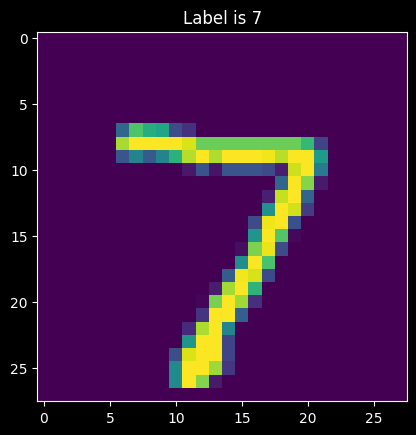

In [35]:
ImageTest=X_test[0, :, :]
Label=L_test[0]


plt.title('Label is {Label}'.format(Label=Label))
plt.imshow(ImageTest)

plt.show()
plt.close()


A. Mean normalization is the first step of the preprocessing of the dataset. Function center() will center the data around 0.

In [36]:
def center(X):
    newX = X - np.mean(X, axis=0)
    return newX

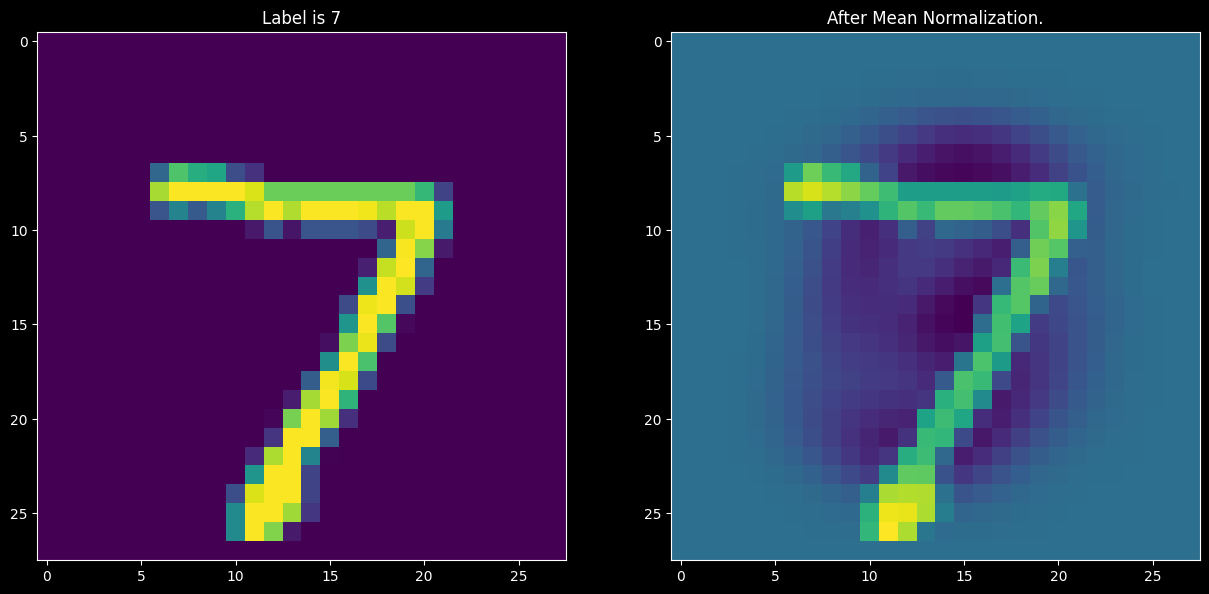

In [37]:
X_testCentered = center(X_test)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(1,2,1)
ax1=plt.subplot(1,2,2)

ImageTestCentered=X_testCentered[0, :, :]

ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(ImageTest)
ax1.set_title('After Mean Normalization.'.format(Label=Label))
ax1.imshow(ImageTestCentered)

plt.show()
plt.close()

B. Standardization is used to put all the features on the same scale. We will do that with function standardize() where we devide each zero centered dimension by its standard deviation.

In [38]:
def standardize(X):
    newX = center(X)/np.std(X, axis=0)
    return newX

C:\Users\Stelios\AppData\Local\Temp\ipykernel_21028\4100552583.py:2: RuntimeWarning: invalid value encountered in divide
  newX = center(X)/np.std(X, axis=0)


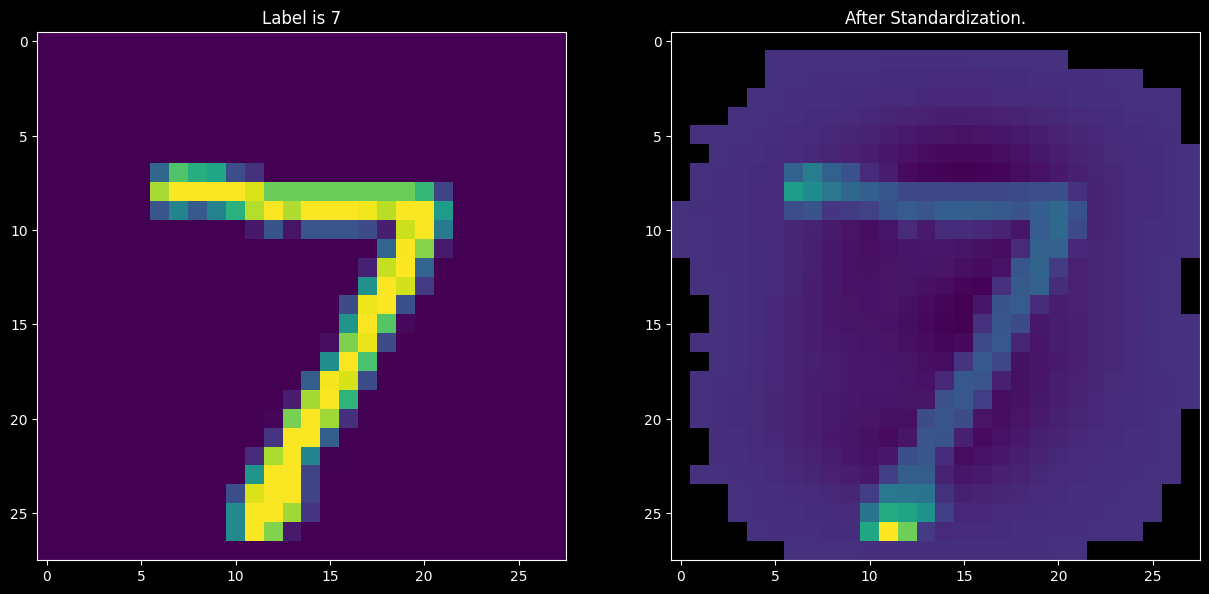

In [39]:
X_testStandardized = standardize(X_test)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(1,2,1)
ax1=plt.subplot(1,2,2)

ImageTestStandardized=X_testStandardized[0, :, :]

ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(ImageTest)
ax1.set_title('After Standardization.'.format(Label=Label))
ax1.imshow(ImageTestStandardized)

plt.show()
plt.close()

C. Whitening means that we want to transform it in a way to have a covariance matrix that is the identity matrix (1 in the diagonal and 0 for the other cells) It's referred to white noise.

First we will decorrelate the data after we center them at zero.

In [40]:
def decorrelate(X):
    #for datasets like MNIST we need to reshape the dataset to 2D array
    X_flat = X.reshape(X.shape[0], -1)
    XCentered = center(X_flat)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X_flat.dot(eigVecs)
    return decorrelated.real

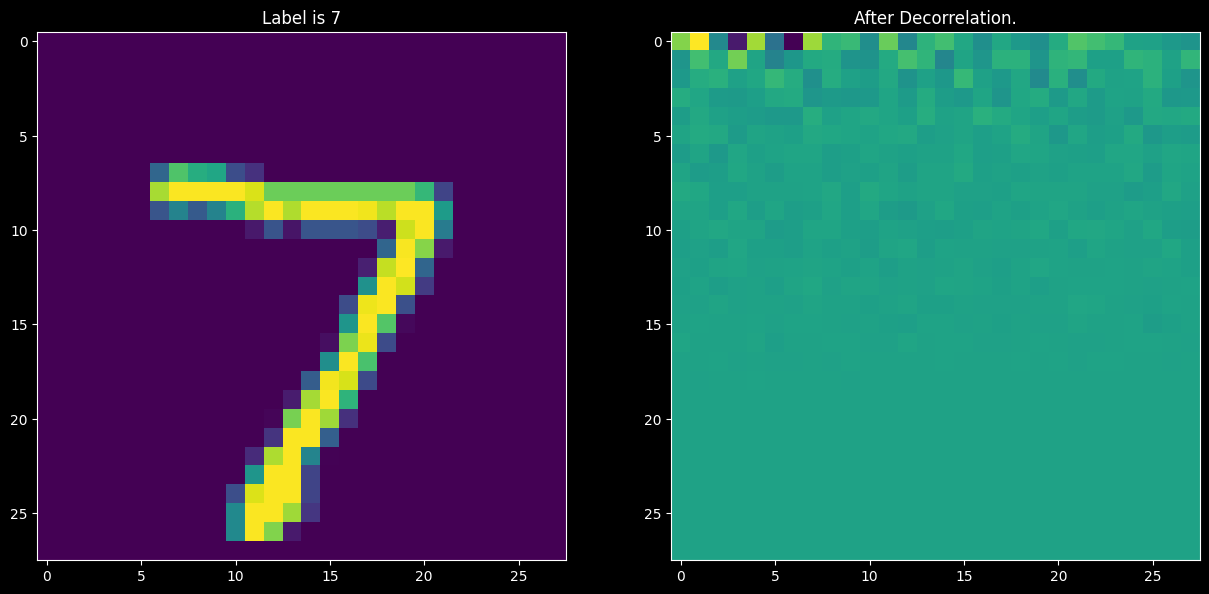

In [41]:
X_testDecorrelated = decorrelate(X_test)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(1,2,1)
ax1=plt.subplot(1,2,2)

ImageTestDecorrelated=X_testDecorrelated[0, :]

ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(ImageTest)
ax1.set_title('After Decorrelation.'.format(Label=Label))
ax1.imshow(ImageTestDecorrelated.reshape(28, 28))

plt.show()
plt.close()

Then we rescale the decorrelated data by dividing each dimension by the square-root of its corresponding eigenvalue to get the whitened dataset.

In [42]:
def whiten(X):
    #for datasets like MNIST we need to reshape the dataset to 2D array
    X_flat = X.reshape(X.shape[0], -1)
    XCentered = center(X_flat)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X_flat.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened.real

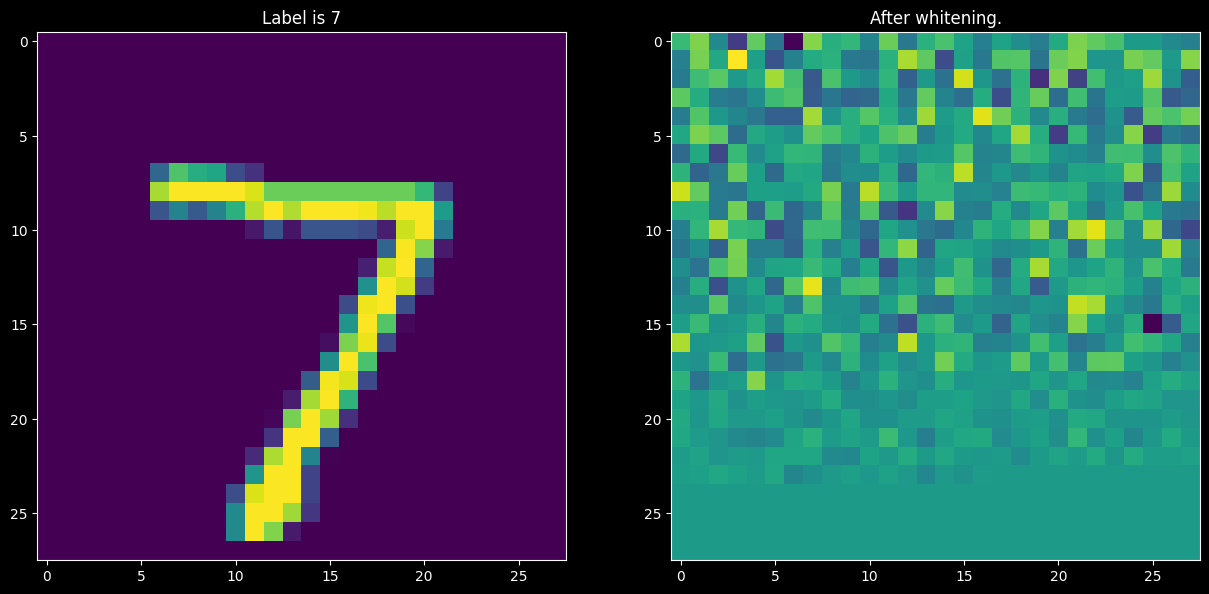

In [43]:
X_testWhitened = whiten(X_test)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(1,2,1)
ax1=plt.subplot(1,2,2)

ImageTestWhitened=X_testWhitened[0, :]

ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(ImageTest)
ax1.set_title('After whitening.'.format(Label=Label))
ax1.imshow(ImageTestWhitened.reshape(28, 28))

plt.show()
plt.close()

Following chapter 3 of the tutorial we will apply ZCA whitening on our dataset.

First we reshape the dataset from (10000,28,28) to (10000,784) in order to have flat image data. Then we need to rescale the images to obtain the range [0,1] by dividing by 255 that is the maximum value of a pixel.

In [44]:
X_flat = X_test.reshape(X_test.shape[0], -1)
X_norm = X_flat / 255.

X_norm = X_norm - X_norm.mean(axis=0)
cov = np.cov(X_norm, rowvar=False)

U,S,V = np.linalg.svd(cov)

epsilon = 0.1
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm.T).T

X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())


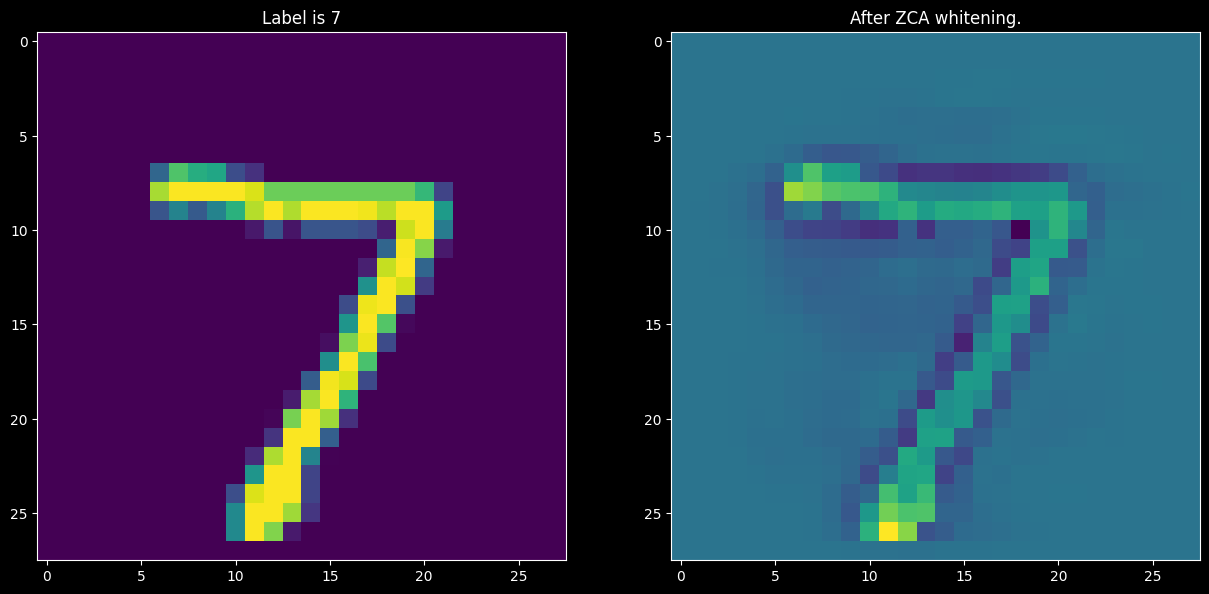

In [45]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(1,2,1)
ax1=plt.subplot(1,2,2)

ImageTestZCA_rescaled=X_ZCA_rescaled[0, :]

ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(ImageTest)
ax1.set_title('After ZCA whitening.'.format(Label=Label))
ax1.imshow(ImageTestZCA_rescaled.reshape(28, 28))

plt.show()
plt.close()


In [46]:
#Traing phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])

Tr_set.shape

(500, 784)

In [47]:
def predict(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    for i in range(num_test):
        distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1)
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [48]:
def predictL2(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    for i in range(num_test):
        distances=np.sqrt(np.sum(np.square(Tr_set-X[i,:]),axis=1))
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [49]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)
Labels_predictedL2=predictL2(Test_images)

print("Accuracy L1:", np.mean(Labels_predicted==L_test))
print("Accuracy L2:", np.mean(Labels_predictedL2==L_test))


Accuracy L1: 0.2649
Accuracy L2: 0.19


Even though we used L2 norm the classification accuracy is decreased to 0.19! But as we can see the accuracy is really low in both cases.

To increase the accuracy we need to rescale the data like we did before whitening earlier. To do this, we will divide the pixel values by 255 in order to have only values between 0 and 1 in the dataset. This way the distance calculation will be more accurate resulting in higher accuracy.

In [50]:
Tr_set = Tr_set /255
Labels_predicted_normL1=predict(Test_images/255)
Labels_predicted_normL2=predictL2(Test_images/255)

print("Accuracy L1:", np.mean(Labels_predicted_normL1==L_test))
print("Accuracy L2:", np.mean(Labels_predicted_normL2==L_test))

Accuracy L1: 0.811
Accuracy L2: 0.8294


This way we managed to increase accuracy to 0.811 from 0.2649 using L1 norm
and to 0.8294 from 0.19 using L2 norm!

In [51]:
def predictL2KNN(X, k):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    for i in range(num_test):
        distances=np.sqrt(np.sum(np.square(Tr_set-X[i,:]),axis=1))

        knn_indices = np.argsort(distances)[:k]
        knn_labels = Ltr_set[knn_indices]
        vote = Counter(knn_labels).most_common(1)
        Lpred[i] = vote[0][0]
    return Lpred

In [54]:
Labels_predicted_3NNL2=predictL2KNN(Test_images/255, 3)
Labels_predicted_5NNL2=predictL2KNN(Test_images/255, 5)

print("Accuracy L2 1-NN:", np.mean(Labels_predicted_normL2==L_test))
print("Accuracy L2 3-NN:", np.mean(Labels_predicted_3NNL2==L_test))
print("Accuracy L2 5-NN:", np.mean(Labels_predicted_5NNL2==L_test))

Accuracy L2 1-NN: 0.8294
Accuracy L2 3-NN: 0.8189
Accuracy L2 5-NN: 0.8092
